In [1]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Explainability

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer
from foreblocks.att import AttentionLayer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
target_len = 10
seq_len = 50
total_len = 300  # Total synthetic time series length

# 1. Create encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = LSTMDecoder(output_size, hidden_size, output_size, num_layers)

attention_module = AttentionLayer(
    method='dot',
    attention_backend='xformers',
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size,
)


model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    #attention_module=attention_module,
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())

# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)
metrics = trainer.metrics(X_val, Y_val)



Training:  52%|█████▏    | 52/100 [00:02<00:02, 21.76epoch/s]

Epoch 50: Train Loss = 0.0096


Training: 100%|██████████| 100/100 [00:04<00:00, 21.06epoch/s]

Epoch 100: Train Loss = 0.0091

Validation Forecast Error Metrics:
  MSE   = 0.012642
  RMSE  = 0.112439
  MAE   = 0.092458


/home/seman/baseline/foreblocks/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Attributions shape: torch.Size([1, 50, 1])


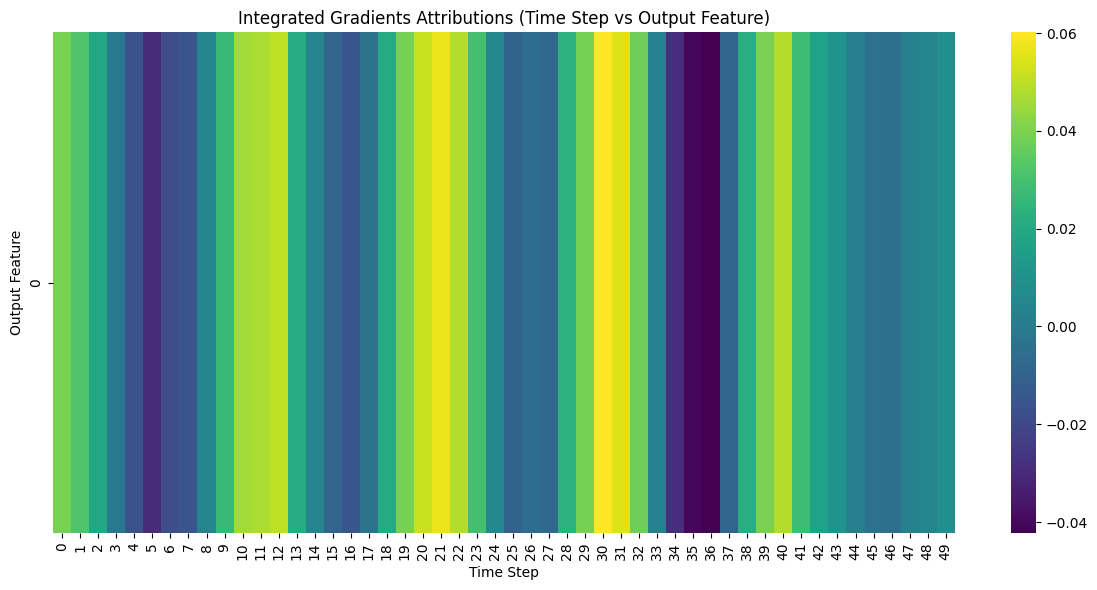

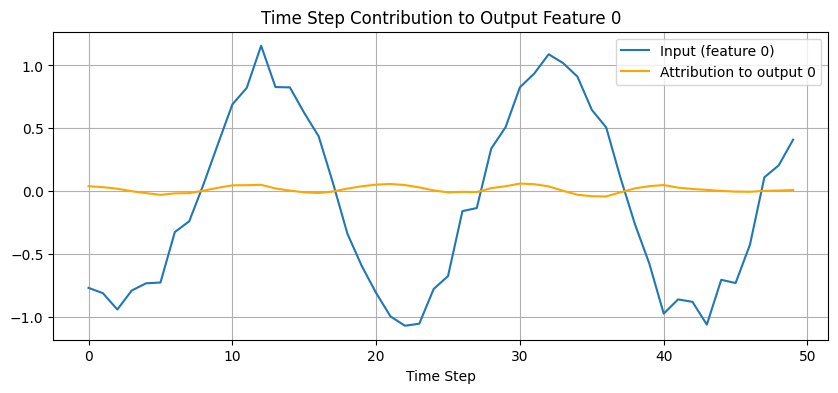

In [3]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import seaborn as sns

input_tensor = X_val[0].unsqueeze(0)  # Shape: [1, seq_len, input_size]
model = model.train()
input_tensor = input_tensor.to('cuda')
target_index = 0  # Index of the target variable to explain
ig = IntegratedGradients(model.attribute_forward)
attributions = ig.attribute(input_tensor, target=target_index)

print("Attributions shape:", attributions.shape)  # Should be [1, seq_len, output_size]

attributions_np = attributions.squeeze(0).detach().cpu().numpy()  # [seq_len, output_size]
input_np = input_tensor.squeeze(0).detach().cpu().numpy()         # [seq_len, input_size]

plt.figure(figsize=(12, 6))
sns.heatmap(attributions_np.T, cmap='viridis', xticklabels=True, yticklabels=True)
plt.xlabel("Time Step")
plt.ylabel("Output Feature")
plt.title("Integrated Gradients Attributions (Time Step vs Output Feature)")
plt.tight_layout()
plt.show()

output_feature_idx = 0
plt.figure(figsize=(10, 4))
plt.plot(input_np[:, 0], label="Input (feature 0)")
plt.plot(attributions_np[:, output_feature_idx], label="Attribution to output 0", color="orange")
plt.xlabel("Time Step")
plt.legend()
plt.title("Time Step Contribution to Output Feature 0")
plt.grid(True)
plt.show()

